# Module 4 Homework: Evaluation
By Shanice Williams

In [1]:
# imports
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm.auto import tqdm

### Data preparation

- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [2]:
df = pd.read_csv("./data/course_lead_scoring.csv")

In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


We do have several columns that have missing values, 4 of which are object type and one numarical.

#### Dealing with object type null values

In [5]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [6]:
for cat in categorical_columns:
    df[cat] = df[cat].fillna('NA')

In [7]:
df.isnull().sum()

lead_source                   0
industry                      0
number_of_courses_viewed      0
annual_income               181
employment_status             0
location                      0
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

#### Dealing with numerical type null values

In [8]:
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [9]:
for num in numerical_columns:
    df[num] = df[num].fillna(0.0)

In [10]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

#### Creating train val test split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [13]:
print(df_train.shape, df_val.shape, df_test.shape)

(876, 8) (293, 8) (293, 8)


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed` [X]
- `interaction_count`
- `annual_income`


In [14]:
from sklearn.metrics import roc_auc_score

In [15]:
numerical_columns = list(df_train.dtypes[df.dtypes != 'object'].index)
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [16]:
scores = {}
for num in numerical_columns:
    scores[num] = roc_auc_score(y_train, df_train[num])

scores


{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92 [X]

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [18]:
categorical = list(df_train.dtypes[df.dtypes == 'object'].index)
numerical = list(df_train.dtypes[df.dtypes != 'object'].index)

In [19]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [20]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [21]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

auc = roc_auc_score(y_val, y_pred)
np.round(auc, 3)

np.float64(0.817)

#### Trying with Standard Scaler

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
def train_with_scaler(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    return dv, model

In [24]:
def predict_with_scaler(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict_proba(X_scaled)[:, 1]

    return y_pred

In [25]:
dv, model = train_with_scaler(df_train, y_train)
y_pred = predict_with_scaler(df_val, dv, model)

auc = roc_auc_score(y_val, y_pred)
np.round(auc, 3)

np.float64(0.92)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545 [X]
* 0.745

In [26]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [28]:
thresholds = np.arange(0.0, 1.0, 0.01)

In [29]:
p_r_scores = {}
for t in thresholds:
    p_r_scores[t] = [precision_score(y_val, (y_pred>= t)), recall_score(y_val, (y_pred>= t))]

p_r_scores

{np.float64(0.0): [0.5836177474402731, 1.0],
 np.float64(0.01): [0.5958188153310104, 1.0],
 np.float64(0.02): [0.608540925266904, 1.0],
 np.float64(0.03): [0.6115107913669064, 0.9941520467836257],
 np.float64(0.04): [0.6204379562043796, 0.9941520467836257],
 np.float64(0.05): [0.6282527881040892, 0.9883040935672515],
 np.float64(0.06): [0.6305970149253731, 0.9883040935672515],
 np.float64(0.07): [0.6377358490566037, 0.9883040935672515],
 np.float64(0.08): [0.6377358490566037, 0.9883040935672515],
 np.float64(0.09): [0.6387832699619772, 0.9824561403508771],
 np.float64(0.1): [0.6412213740458015, 0.9824561403508771],
 np.float64(0.11): [0.6436781609195402, 0.9824561403508771],
 np.float64(0.12): [0.6511627906976745, 0.9824561403508771],
 np.float64(0.13): [0.6536964980544747, 0.9824561403508771],
 np.float64(0.14): [0.6536964980544747, 0.9824561403508771],
 np.float64(0.15): [0.6640316205533597, 0.9824561403508771],
 np.float64(0.16): [0.6666666666666666, 0.9824561403508771],
 np.float64

In [33]:
threshold_df = pd.DataFrame.from_dict(p_r_scores, orient='index',
                                      columns=['precision', 'recall', ])

Text(0.5, 1.0, 'Decision Threshold v Precision and Recall Scores')

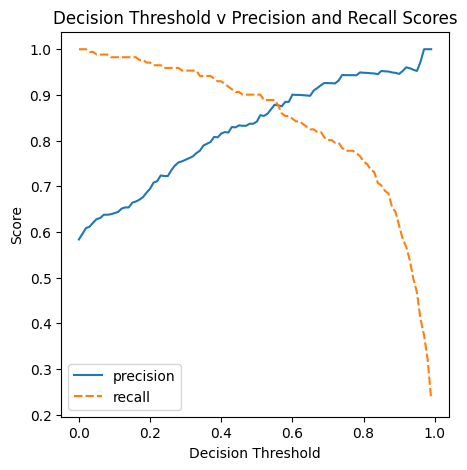

In [45]:
plt.figure(figsize=(5,5))
sns.lineplot(threshold_df)
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Decision Threshold v Precision and Recall Scores")
# plt.axhline(0.875, c='r', ls=':')
# plt.axvline(0.555, c='r', ls=':')

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54 [X]
- 0.74

In [46]:
from sklearn.metrics import f1_score

In [47]:
f1_scores = {}
for t in thresholds:
    f1_scores[t] = [f1_score(y_val, (y_pred>= t))]

In [49]:
res = max(f1_scores, key=f1_scores.get)
res

np.float64(0.55)

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06 [X]
- 0.36



In [50]:
from sklearn.model_selection import KFold

In [51]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]


    y_train = df_train.converted.values
    y_val = df_val.converted.values
    

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)


    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [52]:
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [53]:
np.std(scores)

np.float64(0.03580711942905165)

With Scaling

In [54]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]


    y_train = df_train.converted.values
    y_val = df_val.converted.values
    

    dv, model = train_with_scaler(df_train, y_train)
    y_pred = predict_with_scaler(df_val, dv, model)


    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [55]:
scores

[0.9199732003275515,
 0.9309562905622019,
 0.9051528657439987,
 0.9089352428393525,
 0.9301191765980499]

In [56]:
np.std(scores)

np.float64(0.01058843532701378)

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001 [X]
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [58]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model



In [59]:
n_splits = 5
C = [0.000001, 0.001, 1]

for c in tqdm(C):    

    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):

        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]


        y_train = df_train.converted.values
        y_val = df_val.converted.values
        

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)


        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one